# LDA

In [1]:
import json 
import nltk
import gensim
import pandas as pd
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(1)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matij\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Read and preprocess data

In [2]:
df = pd.read_csv("dataset/data.csv", sep = ";")
df.head()

,text,label
0,fucks sake go away stupid anon — ^ https://t....,abusive
1,Damn dean just put Corbin to sleep. That Match...,abusive
2,@TheRealCamerota THAT BEER BUYING FREAKING IDI...,abusive
3,what idiot called them antacids and not afterb...,abusive
4,RT @gogglepossum: Don't you hate people that p...,abusive


In [3]:
len(df)

54517

In [4]:
labels = df["label"].tolist()
texts = df["text"].tolist()
labels = [x[:4] for x in labels]
#labels

In [5]:
def preprocess(A):
    B = []
  
    for i in range(len(A)):

        text = A[i]
        # remove old style retweet text "RT"
        text = re.sub(r'^RT[\s]+', '', text)

        # remove hyperlinks
        text= re.sub(r'https?:\/\/.*[\r\n]*', '', text)

        # remove hashtags
        # only removing the hash # sign from the word
        text = re.sub(r'#', '', text)

        # remove tagging @
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)

        # remove new line \n
        text = re.sub("\n", "", text)

        # remove zero length tweets
        if(len(text) == 0 ):
            continue

        B.append(text)
        
    return B

In [6]:
texts = preprocess(texts)

In [7]:
stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
#print(len(stopwords))
#stopwords.extend(["like", "damn"])
print(len(stopwords))
stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    
    for token in gensim.utils.simple_preprocess(text):
        if token not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


337


In [8]:
res = []
for text in texts:
    res.append(preprocess(text))


In [9]:
dictionary = gensim.corpora.Dictionary(res)
print(dictionary)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

Dictionary(37001 unique tokens: ['anon', 'away', 'fuck', 'sake', 'stupid']...)
0 anon
1 away
2 fuck
3 sake
4 stupid
5 bore
6 corbin
7 damn
8 dean
9 match
10 show


In [10]:
dictionary.filter_extremes(no_below=5, no_above=0.6, keep_n=100000)

In [11]:
bow_corpus = [dictionary.doc2bow(doc) for doc in res]


In [12]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.6467740881470198),
 (1, 0.4155375954767548),
 (2, 0.14658472445759876),
 (3, 0.554131852891468),
 (4, 0.28365929178108407)]


In [13]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [14]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.085*"moron" + 0.035*"nippl" + 0.027*"go" + 0.021*"retard" + 0.020*"rape" + 0.015*"aid" + 0.014*"loser" + 0.013*"care" + 0.012*"imag" + 0.011*"sourc"


Topic: 1 
Words: 0.047*"vandal" + 0.046*"nigga" + 0.034*"bastard" + 0.024*"tommi" + 0.022*"lick" + 0.019*"hanib" + 0.019*"person" + 0.015*"peopl" + 0.015*"poop" + 0.011*"post"


Topic: 2 
Words: 0.035*"dickhead" + 0.031*"talk" + 0.029*"page" + 0.020*"spanish" + 0.017*"like" + 0.015*"ball" + 0.012*"good" + 0.012*"boob" + 0.012*"peopl" + 0.009*"small"


Topic: 3 
Words: 0.041*"like" + 0.028*"fucker" + 0.018*"want" + 0.018*"mother" + 0.017*"mothjer" + 0.014*"cocksuck" + 0.013*"tell" + 0.012*"know" + 0.011*"pussi" + 0.011*"inform"


Topic: 4 
Words: 0.047*"know" + 0.044*"mexican" + 0.035*"idiot" + 0.033*"women" + 0.022*"assad" + 0.021*"fggt" + 0.021*"delet" + 0.018*"rice" + 0.016*"shit" + 0.016*"dumb"


Topic: 5 
Words: 0.244*"fuck" + 0.071*"faggot" + 0.040*"cunt" + 0.021*"block" + 0.020*"admin" + 0.015*"wikipedia" + 0.012

In [15]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))
    print("\n")

Topic: 0 Word: 0.029*"women" + 0.016*"cock" + 0.012*"fuck" + 0.011*"homo" + 0.011*"admin" + 0.010*"gonna" + 0.010*"suck" + 0.008*"happi" + 0.008*"fine" + 0.008*"retard"


Topic: 1 Word: 0.033*"vandal" + 0.022*"cunt" + 0.013*"fuck" + 0.012*"love" + 0.010*"peni" + 0.009*"woman" + 0.008*"aliv" + 0.008*"fucker" + 0.007*"queer" + 0.006*"mother"


Topic: 2 Word: 0.050*"fuck" + 0.021*"bitch" + 0.021*"nigger" + 0.015*"dick" + 0.015*"suck" + 0.012*"idiot" + 0.009*"hate" + 0.007*"like" + 0.007*"page" + 0.007*"user"


Topic: 3 Word: 0.015*"wiki" + 0.009*"feminazi" + 0.008*"loser" + 0.008*"fuck" + 0.007*"jerk" + 0.005*"know" + 0.005*"like" + 0.005*"imag" + 0.005*"unblock" + 0.005*"articl"


Topic: 4 Word: 0.014*"like" + 0.013*"fuck" + 0.007*"shut" + 0.007*"video" + 0.006*"shit" + 0.006*"twat" + 0.006*"block" + 0.005*"peopl" + 0.005*"know" + 0.004*"stupid"


Topic: 5 Word: 0.049*"faggot" + 0.014*"fuck" + 0.007*"mother" + 0.007*"huge" + 0.007*"fuckin" + 0.005*"motherfuck" + 0.005*"bitch" + 0.005*"wa

In [16]:
#lda_model = lda_model_tfidf
#bow_corpus = corpus_tfidf

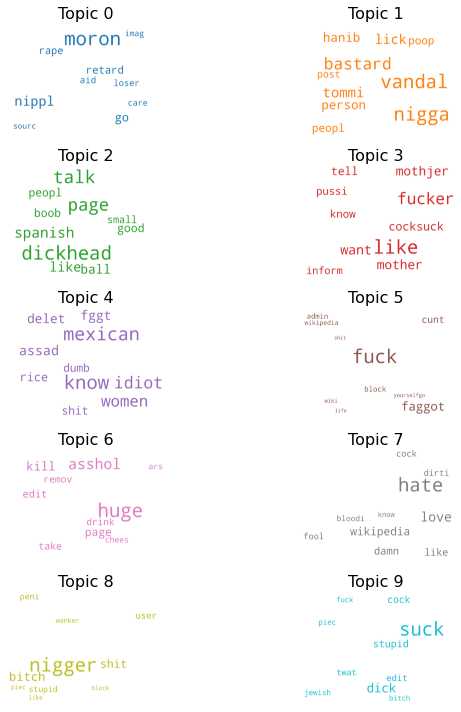

In [19]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [20]:
topics = lda_model.show_topics(15, formatted=False)
topics

[(0,
  [('moron', 0.08527298),
   ('nippl', 0.03481825),
   ('go', 0.02655508),
   ('retard', 0.021187682),
   ('rape', 0.019637657),
   ('aid', 0.015467508),
   ('loser', 0.014203355),
   ('care', 0.012666163),
   ('imag', 0.0119659575),
   ('sourc', 0.01098988)]),
 (1,
  [('vandal', 0.046858136),
   ('nigga', 0.0461656),
   ('bastard', 0.033532485),
   ('tommi', 0.024342038),
   ('lick', 0.0221215),
   ('hanib', 0.019225027),
   ('person', 0.019101117),
   ('peopl', 0.01480735),
   ('poop', 0.014590486),
   ('post', 0.011446317)]),
 (2,
  [('dickhead', 0.03516638),
   ('talk', 0.030973384),
   ('page', 0.029181842),
   ('spanish', 0.019623846),
   ('like', 0.016567124),
   ('ball', 0.015012696),
   ('good', 0.012208122),
   ('boob', 0.011966049),
   ('peopl', 0.011774176),
   ('small', 0.009253344)]),
 (3,
  [('like', 0.04102574),
   ('fucker', 0.028451087),
   ('want', 0.01835499),
   ('mother', 0.01754495),
   ('mothjer', 0.017003935),
   ('cocksuck', 0.014057439),
   ('tell', 0.01

In [21]:
df1 = pd.DataFrame(columns = ["text"])

for i in range(len(topics)):
    
    words = [x[0] for x in topics[i][1]]
    words = ", ".join(words[:5])
    print(f"{i} {words}")
    df1 = df1.append({"text": words}, ignore_index = True)
    
df1

0 moron, nippl, go, retard, rape
1 vandal, nigga, bastard, tommi, lick
2 dickhead, talk, page, spanish, like
3 like, fucker, want, mother, mothjer
4 know, mexican, idiot, women, assad
5 fuck, faggot, cunt, block, admin
6 huge, asshol, kill, page, edit
7 hate, love, wikipedia, damn, like
8 nigger, bitch, shit, user, peni
9 suck, dick, stupid, cock, edit


,text
0,"moron, nippl, go, retard, rape"
1,"vandal, nigga, bastard, tommi, lick"
2,"dickhead, talk, page, spanish, like"
3,"like, fucker, want, mother, mothjer"
4,"know, mexican, idiot, women, assad"
5,"fuck, faggot, cunt, block, admin"
6,"huge, asshol, kill, page, edit"
7,"hate, love, wikipedia, damn, like"
8,"nigger, bitch, shit, user, peni"
9,"suck, dick, stupid, cock, edit"


In [22]:
print(len(topics))

10


In [23]:
lda_model[bow_corpus[1]]

[(0, 0.012523435),
 (1, 0.0125246905),
 (2, 0.012522633),
 (3, 0.012525685),
 (4, 0.012524711),
 (5, 0.53902656),
 (6, 0.24412969),
 (7, 0.1291775),
 (8, 0.012521016),
 (9, 0.012524048)]

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=res, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.380152472826772

Coherence Score:  0.506628157281386


## This are some internal tests and results are not used in the report - not further explained

In [25]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.097990  0.028944       1        1  15.198527
3     -0.019929 -0.017252       2        1  14.681725
2     -0.079810 -0.023696       3        1  10.121364
9      0.093109  0.054932       4        1   9.679407
6     -0.098828  0.068139       5        1   9.676005
8      0.314806  0.049237       6        1   8.923086
7     -0.072042 -0.096803       7        1   8.413311
4     -0.017459 -0.186479       8        1   8.108106
1     -0.063568 -0.112566       9        1   7.955501
0     -0.154270  0.235544      10        1   7.242967, topic_info=         Term          Freq         Total Category  logprob  loglift
2        fuck  31321.000000  31321.000000  Default  30.0000  30.0000
5894   nigger  14794.000000  14794.000000  Default  29.0000  29.0000
920      suck  11370.000000  11370.000000  Default  28.0000  28.0000
1825   faggot   8149.000000   8149.000000  Default  27.0000  27.0000
25       hate   5997.000000   5997.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
21      think    499.930237   4037.926570  Topic10  -4.6940   0.5361
1234  obvious    212.153519    590.379424  Topic10  -5.5511   1.6017
26      peopl    341.177156   4700.246289  Topic10  -5.0761   0.0022
108      hell    258.268418   1858.810986  Topic10  -5.3545   0.6514
1754    white    217.011150    925.798225  Topic10  -5.5285   1.1744

[663 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
698       1  0.307411        abus
698       2  0.215522        abus
698       3  0.011695        abus
698       4  0.003341        abus
698       5  0.011695        abus
...     ...       ...         ...
305       6  0.024304        year
305       7  0.181414        year
305       8  0.059025        year
8945      1  0.999446  yourselfgo
7950      2  0.984989        ŷour

[1910 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 3, 10, 7, 9, 8, 5, 2, 1])

In [26]:
test = lda_model[bow_corpus[3]]
test

C:\Users\matij\anaconda3\envs\nlp-test\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.033336744),
 (1, 0.033336833),
 (2, 0.03335548),
 (3, 0.03334616),
 (4, 0.69992673),
 (5, 0.033338282),
 (6, 0.033339318),
 (7, 0.033335418),
 (8, 0.03333949),
 (9, 0.03334557)]

In [27]:
def argmax(pairs):
    return max(pairs, key=lambda x: x[1])[0]

C:\Users\matij\anaconda3\envs\nlp-test\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
old_labels = dict()
for i in range(len(bow_corpus)):
    key = max(lda_model[bow_corpus[i]], key=lambda x: x[1])[0]
    x = old_labels.get(key)
    if x is None:
        x = []
        old_labels[key] = x
    x.append(labels[i])

C:\Users\matij\anaconda3\envs\nlp-test\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
for i in range(10):
    labs, occ = np.unique(old_labels[i], return_counts = True)
    print(f"{i}")
    for tup in list(zip(labs, occ/sum(occ))):
        print(tup)

0
('abus', 0.08900638907248293)
('bene', 0.10619079092311082)
('cybe', 0.007270323859881031)
('hate', 0.06961885877946684)
('iden', 0.015421899096717338)
('insu', 0.09627671293236395)
('obsc', 0.08746419916281119)
('offe', 0.014540647719762063)
('prof', 0.016743776162150253)
('raci', 0.0039656311962987445)
('sexi', 0.1130204890945142)
('spam', 0.1868252919145186)
('thre', 0.008592200925313946)
('toxi', 0.18506278916060806)
1
('abus', 0.10708696624189581)
('bene', 0.029510395707578806)
('cybe', 0.004694835680751174)
('hate', 0.0628213726805276)
('iden', 0.017214397496087636)
('insu', 0.11781801922646994)
('obsc', 0.11871227364185111)
('offe', 0.005812653699977644)
('prof', 0.008048289738430584)
('raci', 0.004694835680751174)
('sexi', 0.09903867650346523)
('spam', 0.17929801028392578)
('thre', 0.0053655264922870555)
('toxi', 0.23988374692600045)
2
('abus', 0.07168059424326834)
('bene', 0.01615598885793872)
('cybe', 0.007056638811513464)
('hate', 0.05589600742804086)
('iden', 0.0200557103

C:\Users\matij\anaconda3\envs\nlp-test\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
old_labels = dict()
for i in range(len(bow_corpus)):
    key = labels[i]
    new_topic = max(lda_model[bow_corpus[i]], key=lambda x: x[1])[0]
    x = old_labels.get(key)
    if x is None:
        x = []
        old_labels[key] = x
    x.append(new_topic)

C:\Users\matij\anaconda3\envs\nlp-test\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
for key in old_labels.keys():
    labs, occ = np.unique(old_labels[key], return_counts = True)
    print(f"{key}")
    for tup in list(zip(labs, occ/sum(occ))):
        print(tup)

abus
(0, 0.09581263307310149)
(1, 0.11237284125857583)
(2, 0.09202744263070736)
(3, 0.16441920984149516)
(4, 0.12301868937780933)
(5, 0.11071682044002838)
(6, 0.09179086822805772)
(7, 0.10172699313934232)
(8, 0.047551454932576294)
(9, 0.06056304707830613)
hate
(0, 0.10500165617754223)
(1, 0.09373964889036104)
(2, 0.10168930109307718)
(3, 0.26300099370652535)
(4, 0.08049022855250083)
(5, 0.048029148724743294)
(6, 0.13150049685326268)
(7, 0.09506459092414707)
(8, 0.036104670420669095)
(9, 0.04537926465717125)
spam
(0, 0.10896941660241583)
(1, 0.10267283474685171)
(2, 0.110254433307633)
(3, 0.22719095348239526)
(4, 0.0864816242611154)
(5, 0.029683885890516577)
(6, 0.15612952968388588)
(7, 0.08673862760215882)
(8, 0.033795939347211514)
(9, 0.058082755075815985)
offe
(0, 0.12643678160919541)
(1, 0.04980842911877394)
(2, 0.10919540229885058)
(3, 0.43486590038314177)
(4, 0.04597701149425287)
(5, 0.03065134099616858)
(6, 0.05747126436781609)
(7, 0.06704980842911877)
(8, 0.034482758620689655)
(

C:\Users\matij\anaconda3\envs\nlp-test\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
